Everything up to the pseudo-voights is the same as for the non-augmented data, so we can just copy all the files from the non-augmented data to the file and continue from there.

Generate the pseudo-voights. This notebook will be for augmented data, so we will consider a variety of peak shapes

In [1]:
import pandas as pd
import numpy as np
import argparse
import os
import random
import torch
import scipy.stats as stats

try:
    # Argument parsing
    parser = argparse.ArgumentParser(description='Parallel XRD Simulation')
    parser.add_argument('--n_workers', type=int, help='Total number of workers')
    parser.add_argument('--worker_num', type=int, help='Current worker number (0-indexed)')
    args = parser.parse_args()

    n_workers = args.n_workers
    worker_num = args.worker_num
except:
    n_workers = 100
    worker_num = 0
    
data_dir = '/home/gridsan/tmackey/cdvae/data/mp_20_final_augmented_reproduction/'

train_path = os.path.join(data_dir, 'train.csv')
val_path = os.path.join(data_dir, 'val.csv')
test_path = os.path.join(data_dir, 'test.csv')

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

dataframes = {'train': train_df, 'val': val_df, 'test': test_df}

for name, data in dataframes.items():
    data['xrd_peak_locations'] = data['xrd_peak_locations'].apply(
        lambda x: [float(i) for i in x.strip('[]').split(',')]
    )

    #make sure we can read in the diffraction patterns
    data['xrd_peak_intensities'] = data['xrd_peak_intensities'].apply(
        lambda x: [float(i) for i in x.strip('[]').split(',')]
    )

def caglioti_fwhm(theta, U, V, W):
    """
    Calculate the FWHM using the Caglioti formula.
    theta: float, the angle in degrees
    U, V, W: Caglioti parameters
    """
    rad_theta = np.radians(theta / 2)  # Convert theta to radians
    return (U * np.tan(rad_theta)**2 + V * np.tan(rad_theta) + W)**0.5

def pseudo_voigt(x, center, amplitude, U, V, W, eta, alpha, loc, scale, pref_or_noise = False):
    """
    Pseudo-Voigt function using Caglioti FWHM.
    x: array-like, the independent variable
    center: float, the center of the peak
    amplitude: float, the height of the peak
    U, V, W: Caglioti parameters
    eta: float, the fraction of the Lorentzian component (0 <= eta <= 1)
    """
    fwhm = caglioti_fwhm(center, U, V, W)
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))  # Convert FWHM to sigma for Gaussian

    if pref_or_noise:
        # Generate random noise from a gamma distribution
        gamma_samples = stats.gamma.rvs(a=alpha, loc=loc, scale=scale)

        #multiply the amplitude by the gamma samples to simulate the effects of preferred orientation
        amplitude = amplitude * gamma_samples
    
    lorentzian = amplitude * (fwhm**2 / ((x - center)**2 + fwhm**2))
    gaussian = amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

    return eta * lorentzian + (1 - eta) * gaussian

def superimposed_pseudo_voigt(x, xy_merge, U, V, W, eta, alpha, loc, scale, pref_or_noise = False):
    """
    Superimpose multiple pseudo-Voigt functions using Caglioti FWHM.
    x: array-like, the independent variable
    xy_merge: nx2 array, first column is peak locations, second column is intensities
    U, V, W: Caglioti parameters
    eta: float, the fraction of the Lorentzian component (0 <= eta <= 1)
    """
    total = np.zeros_like(x)
    for row in xy_merge:
        center, amplitude = row
        total += pseudo_voigt(x, center, amplitude, U, V, W, eta, alpha, loc, scale, pref_or_noise)
    total = total / max(total)
    return total

# Function to simulate XRD for each row
def simulate_pv_xrd_for_row(row_tuple, x, eta, U, V, W, alpha, loc, scale, pref_or_noise = False):
    index, row = row_tuple  # Unpack the tuple
    print(index, end='\r')
    # Combine peak locations and intensities into a single array
    xy_merge = np.column_stack((row['xrd_peak_locations'], row['xrd_peak_intensities']))

    sim_xrd = superimposed_pseudo_voigt(x, xy_merge, U, V, W, eta, alpha, loc, scale, pref_or_noise)

    return sim_xrd

def apply_simulation(data, x, eta, U, V, W, worker_num, 
                     n_workers, peak_shape, alpha, loc, scale, pref_or_noise = False):
    
    # Split data for the current worker
    chunk_size = len(data) // n_workers
    start_idx = worker_num * chunk_size
    end_idx = None if worker_num == n_workers - 1 else start_idx + chunk_size # Last worker gets the rest
    worker_data = data.iloc[start_idx:end_idx]

    print("Worker", worker_num, "processing", len(worker_data), "rows")
    print("start index:", start_idx, "end index:", end_idx)
    
    # Process using a list comprehension
    results = [simulate_pv_xrd_for_row((idx, row), x, eta, U, V, W,
                                        alpha, loc, scale, pref_or_noise) for idx, row in worker_data.iterrows()]
    
    #turn the list of numpy arrays into a numpy array
    results = np.stack(results)

    tensor = torch.from_numpy(results).float()

    tensor = tensor.reshape(tensor.shape[0], 1, tensor.shape[1])

    data_dict = {}
    for i in range(len(worker_data)):
        key = worker_data['material_id'].iloc[i] + "_" + str(peak_shape)
        data_dict[key] = tensor[i]

    return data_dict

peak_shapes = [(0.05, -0.06, 0.07), (0.05, -0.01, 0.01),
                   (0.0, 0.0, 0.01), (0.0, 0.0, random.uniform(0.001, 0.1))] #peak shapes from the npj cm paper

x = np.arange(5, 90, 0.010) #typical range for the RRUFF data 
eta = 0 #fully gaussian peaks as simulated in the npj cm paper
pref_or_noise = True
alpha, loc, scale = 2.1299178874418425, 0, 0.3836337942728039 #gamma distribution parameters from data in a previous notebook

for name, data in dataframes.items():
    # Assuming peak_shapes is defined elsewhere in your code
    for peak_shape, (U, V, W) in enumerate(peak_shapes): 
        #no pref orientation noise on the second peak shape 
        if peak_shape == 1:
            pref_or_noise = False

        sim_pv_xrd_intensities_dict = apply_simulation(data, x, eta, U, V, W, worker_num, n_workers, peak_shape,
                                                       alpha, loc, scale, pref_or_noise) #this going to be a n x 8192 array 

        # Save results as a numpy array
        output_filename = data_dir + f'{name}_sim_pv_xrd_intensities_{peak_shape}_worker_{worker_num}.pt'
        torch.save(sim_pv_xrd_intensities_dict, output_filename)
        print("Saved to {}".format(output_filename))

        #reset pref_or_noise
        pref_or_noise = True

print("Simulation completed for worker number:", worker_num)

usage: ipykernel_launcher.py [-h] [--n_workers N_WORKERS]
                             [--worker_num WORKER_NUM]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/gridsan/tmackey/.local/share/jupyter/runtime/kernel-v2-4629230ADcXjLpxqRR.json


Worker 0 processing 360 rows
start index: 0 end index: 360
Saved to /home/gridsan/tmackey/cdvae/data/mp_20_final_augmented_reproduction/train_sim_pv_xrd_intensities_0_worker_0.pt
Worker 0 processing 360 rows
start index: 0 end index: 360
Saved to /home/gridsan/tmackey/cdvae/data/mp_20_final_augmented_reproduction/train_sim_pv_xrd_intensities_1_worker_0.pt
Worker 0 processing 360 rows
start index: 0 end index: 360
Saved to /home/gridsan/tmackey/cdvae/data/mp_20_final_augmented_reproduction/train_sim_pv_xrd_intensities_2_worker_0.pt
Worker 0 processing 360 rows
start index: 0 end index: 360
Saved to /home/gridsan/tmackey/cdvae/data/mp_20_final_augmented_reproduction/train_sim_pv_xrd_intensities_3_worker_0.pt
Worker 0 processing 45 rows
start index: 0 end index: 45
Saved to /home/gridsan/tmackey/cdvae/data/mp_20_final_augmented_reproduction/val_sim_pv_xrd_intensities_0_worker_0.pt
Worker 0 processing 45 rows
start index: 0 end index: 45
Saved to /home/gridsan/tmackey/cdvae/data/mp_20_fina

Merge

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch 
import os
import random 

num_workers = 1
dataset_names =  ['train', 'test', 'val']
data_source = "mp_20"
data_dir = f"/home/gridsan/tmackey/cdvae/data/mp_20_final_augmented_reproduction/"
peak_shapes = [(0.05, -0.06, 0.07), (0.05, -0.01, 0.01),
                   (0.0, 0.0, 0.01), (0.0, 0.0, random.uniform(0.001, 0.1))] #peak shapes from the npj cm paper

for name in dataset_names:
    for peak_shape, (U, V, W) in enumerate(peak_shapes):
        total_dict = {}
        for worker_num in tqdm(range(num_workers)):
            subdict = torch.load(data_dir + f'{name}_sim_pv_xrd_intensities_{peak_shape}_worker_{worker_num}.pt')
            total_dict.update(subdict)
        output_filepath = os.path.join(data_dir, f'{name}_sim_pv_xrd_intensities_{peak_shape}.pt')
        torch.save(total_dict, output_filepath)
        print(f"Saved {name} dataset")

100%|██████████| 1/1 [00:00<00:00, 32.44it/s]


Saved train dataset


100%|██████████| 1/1 [00:00<00:00, 40.13it/s]


Saved train dataset


100%|██████████| 1/1 [00:00<00:00, 31.39it/s]


Saved train dataset


100%|██████████| 1/1 [00:00<00:00, 71.76it/s]


Saved train dataset


100%|██████████| 1/1 [00:00<00:00, 310.18it/s]


Saved test dataset


100%|██████████| 1/1 [00:00<00:00, 198.87it/s]


Saved test dataset


100%|██████████| 1/1 [00:00<00:00, 170.59it/s]


Saved test dataset


100%|██████████| 1/1 [00:00<00:00, 336.89it/s]


Saved test dataset


100%|██████████| 1/1 [00:00<00:00, 227.94it/s]


Saved val dataset


100%|██████████| 1/1 [00:00<00:00, 359.59it/s]


Saved val dataset


100%|██████████| 1/1 [00:00<00:00, 265.65it/s]


Saved val dataset


100%|██████████| 1/1 [00:00<00:00, 370.82it/s]

Saved val dataset


Load in the data to double check 

In [3]:
import pandas as pd
import numpy as np
import torch

In [4]:
train_dict = torch.load('/home/gridsan/tmackey/cdvae/data/mp_20_final_augmented_reproduction/train_sim_pv_xrd_intensities_0.pt')
train_df = pd.read_csv('/home/gridsan/tmackey/cdvae/data/mp_20_final_augmented_reproduction/train.csv')

In [5]:
import matplotlib.pyplot as plt

In [6]:
#get the first key
key = list(train_dict.keys())[1]

In [7]:
key

'mp-624492_0'

In [8]:
#find the entry in train_df with mp-624492 as the material_id
train_df[train_df['material_id'] == 'mp-624492']

,Unnamed: 0,material_id,formation_energy_per_atom,band_gap,pretty_formula,e_above_hull,elements,cif,spacegroup.number,xrd,xrd_peak_locations,xrd_peak_intensities,atomic_numbers,disc_sim_xrd
1,7892,mp-624492,-0.167614,0.0,Li(Fe3Ge2)2,0.0,"['Li', 'Fe', 'Ge']",# generated using pymatgen\ndata_Li(Fe3Ge2)2\n...,166,DiffractionPattern\n$2\Theta$: [13.62107185 20...,"[13.62107184670743, 20.825783406557477, 22.287...","[24.600372319557255, 13.30601823126662, 22.409...","[3, 26, 26, 26, 26, 26, 26, 32, 32, 32, 32]",[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...


In [9]:
import ast

In [10]:
xrd_peak_locations = ast.literal_eval(train_df[train_df['material_id'] == 'mp-624492']['xrd_peak_locations'].values[0])
xrd_peak_intensities = ast.literal_eval(train_df[train_df['material_id'] == 'mp-624492']['xrd_peak_intensities'].values[0])

Text(0.5, 1.0, 'Simulated XRD for mp-624492')

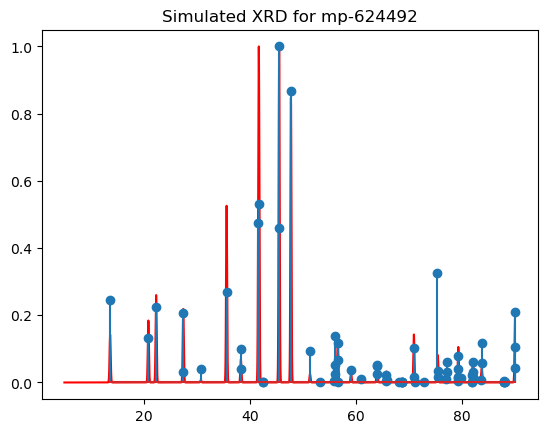

In [11]:
plt.plot(np.arange(5,90,0.01),list(train_dict[key].numpy().flatten()), color = 'red')
#plot the original XRD
plt.stem(xrd_peak_locations, xrd_peak_intensities / np.max(xrd_peak_intensities))
plt.title('Simulated XRD for mp-624492')


Merge together the data from different peak shapes

In [12]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch 
import os
import random

num_workers = 1
dataset_names =  ['train', 'test', 'val']
data_source = "mp_20"
data_dir = '/home/gridsan/tmackey/cdvae/data/mp_20_final_augmented_reproduction/'
peak_shapes = [(0.05, -0.06, 0.07), (0.05, -0.01, 0.01),
                   (0.0, 0.0, 0.01), (0.0, 0.0, random.uniform(0.001, 0.1))] #peak shapes from the npj cm paper

for name in dataset_names:
    total_dict = {}
    for peak_shape, (U, V, W) in enumerate(peak_shapes):
        for worker_num in tqdm(range(num_workers)):
            subdict = torch.load(data_dir + f'{name}_sim_pv_xrd_intensities_{peak_shape}_worker_{worker_num}.pt')
            total_dict.update(subdict)
    print("total_dict length", len(total_dict))
    output_filepath = os.path.join(data_dir, f'{name}_pv_xrd.pt')
    torch.save(total_dict, output_filepath)
    print(f"Saved {name} dataset")

100%|██████████| 1/1 [00:00<00:00, 35.70it/s]


total_dict length 1440
Saved train dataset


100%|██████████| 1/1 [00:00<00:00, 193.17it/s]


total_dict length 180
Saved test dataset


100%|██████████| 1/1 [00:00<00:00, 229.06it/s]


total_dict length 180
Saved val dataset
